In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tweepy
import simplejson as json
from dill import pickle
import dill
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 2*matplotlib.rcParams['savefig.dpi']

import seaborn as sns

In [2]:
twitter_api_key = 'DI48EpYQvUL6ljgVpHVl1HRHf'
consumer_key = 'DI48EpYQvUL6ljgVpHVl1HRHf'
consumer_secret = 'USHDIRxUwT7zC8W6zQ66n1ufYZprmHzO03JvDBAkS9Zy49Pu5z'
access_token = '432725860-fBs7K5pdQDpcbF3OT8pAwh4MfKHR4WOI8GDJQOuF'
access_token_secret = '0J986zfrwz0RQh4yphQ3YhqrdnNIMX7djqdBSEmfjfJrN'


In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)


In [4]:
def extract_twitter_params(username):
    try:
        user = api.get_user(username,monitor_rate_limit=True, wait_on_rate_limit=True)
        return {'user':username,
                'follower count':user.followers_count,
                'following count':user.friends_count,
                'tweet count':user.statuses_count}
    except tweepy.TweepError:
        print 'Tweep Error for username: ',username
        return {'user':username,
                'follower count':np.NaN,
                'following count':np.NaN,
                'tweet count':np.NaN}
def stats_of_user(username):
    public_tweets = get_tweets(username)
    for tweet in public_tweets:
        users = re.findall('@\S+',tweet.text)
        while users:
            yield extract_twitter_params(users.pop()[1:])

def stats_from_tweets(tweets):
    user_set = []
    for tweet in tweets:
        for ent in tweet.entities['user_mentions']:
            user_set.append(ent['screen_name'])
    user_set = list(set(user_set))
    stats = [extract_twitter_params(user) for user in user_set]
    return pd.DataFrame(stats)
        
def get_tweets(username):
    tweets = []
    new_tweets = api.user_timeline(screen_name = username,count=200,include_rts=True,monitor_rate_limit=True, wait_on_rate_limit=True)
    tweets.extend(new_tweets)
    
    oldest = tweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print "getting tweets before %s" % (oldest)
        
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = username,count=200,max_id=oldest,include_rts=True,monitor_rate_limit=True, wait_on_rate_limit=True)
    
        #save most recent tweets
        tweets.extend(new_tweets)
    
        #update the id of the oldest tweet less one
        oldest = tweets[-1].id - 1
        
        print "...%s tweets downloaded so far" % (len(tweets))
    return tweets

    
 

In [9]:
harrys_tweets = get_tweets('harrys')

getting tweets before 593082595015073791
...400 tweets downloaded so far
getting tweets before 588724805718835200
...600 tweets downloaded so far
getting tweets before 585086041033461759
...800 tweets downloaded so far
getting tweets before 582547663868006399
...1000 tweets downloaded so far
getting tweets before 580382077637513216
...1200 tweets downloaded so far
getting tweets before 577487595627753471
...1400 tweets downloaded so far
getting tweets before 574944185884786687
...1600 tweets downloaded so far
getting tweets before 572386646814953471
...1800 tweets downloaded so far
getting tweets before 569902268167925759
...2000 tweets downloaded so far
getting tweets before 567402646622187520
...2200 tweets downloaded so far
getting tweets before 564809012743766015
...2400 tweets downloaded so far
getting tweets before 560560001429688319
...2600 tweets downloaded so far
getting tweets before 557912972551811072
...2800 tweets downloaded so far
getting tweets before 553570715589693439


In [10]:
len(harrys_tweets)

3228

In [11]:
harrys_tweets_df = pd.Series(harrys_tweets)
harrys_tweets_df.to_pickle('harrys_tweets.pkl')

In [5]:
harrys_tweets_df = pd.read_pickle('harrys_tweets.pkl')
harrys_tweets = list(harrys_tweets_df)

In [128]:
harrys_tweets_stats = stats_from_tweets(harrys_tweets)

Tweep Error for username:  BfloBrewHound
Tweep Error for username:  RDRoberts1980
Tweep Error for username:  AnthonyKadir
Tweep Error for username:  kw_collins
Tweep Error for username:  Culligan27
Tweep Error for username:  zuwysugemef
Tweep Error for username:  jamynimikuh
Tweep Error for username:  WhatFredSays
Tweep Error for username:  reallygoodemail
Tweep Error for username:  supufesawodi
Tweep Error for username:  jagjr2570
Tweep Error for username:  LarryPrettion
Tweep Error for username:  Hoss423


In [131]:
harrys_tweets_stats.to_pickle('harrys_tweets_stats.pkl')

In [6]:
harrys_tweets_stats = pd.read_pickle('harrys_tweets_stats.pkl')

In [7]:
log_follower_count = [np.log10(fc) for fc in harrys_tweets_stats['follower count']]
log_following_count = [np.log10(fc) for fc in harrys_tweets_stats['following count']]
log_tweet_count = [np.log10(tc) for tc in harrys_tweets_stats['tweet count']]
harrys_tweets_stats['log follower count'] = log_follower_count
harrys_tweets_stats['log following count'] = log_following_count
harrys_tweets_stats['log tweet count'] = log_tweet_count
harrys_tweets_stats.loc[harrys_tweets_stats['log follower count'] == -np.inf] = 0
harrys_tweets_stats.loc[harrys_tweets_stats['log following count'] == -np.inf] = 0
harrys_tweets_stats.loc[harrys_tweets_stats['log tweet count'] == -np.inf] = 0

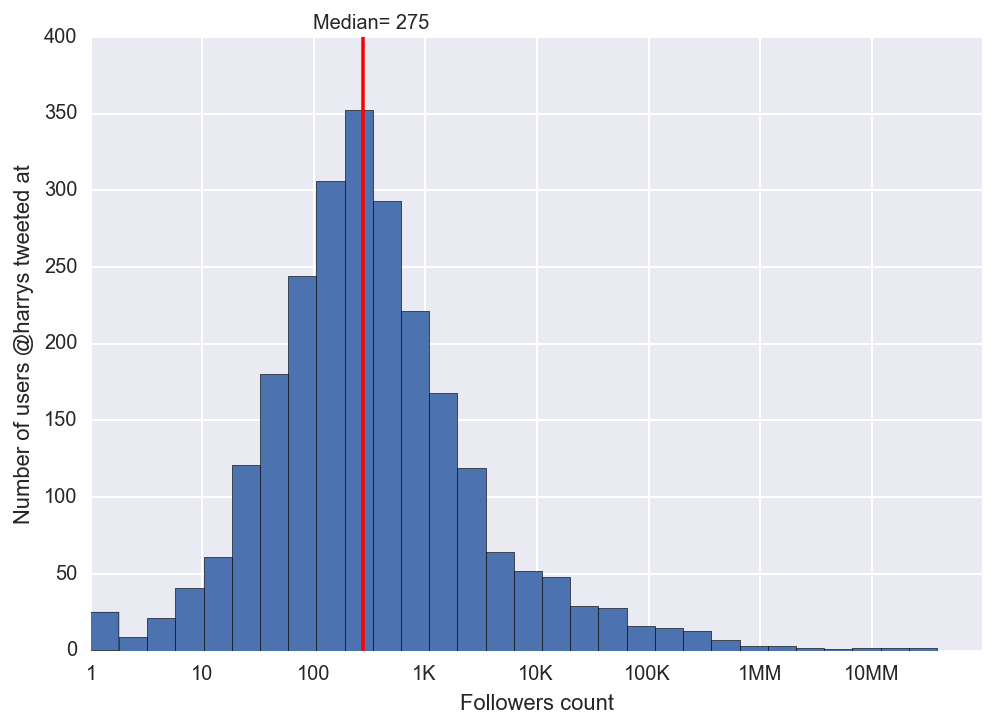

In [8]:
ax = harrys_tweets_stats['log follower count'].hist(bins=30)
ax.set_xticklabels(['1','10','100','1K','10K','100K','1MM','10MM'])
ax.set_xlabel('Followers count')
ax.set_ylabel('Number of users @harrys tweeted at')
ax.axvline(x=harrys_tweets_stats['log follower count'].median(),color='r')#,label='Median:')# '+str(harrys_tweets_stats['log follower count'].median()))
ax.text(harrys_tweets_stats['log follower count'].median()-.45,405,'Median= '+str(int(10**harrys_tweets_stats['log follower count'].median())),rotation=0)

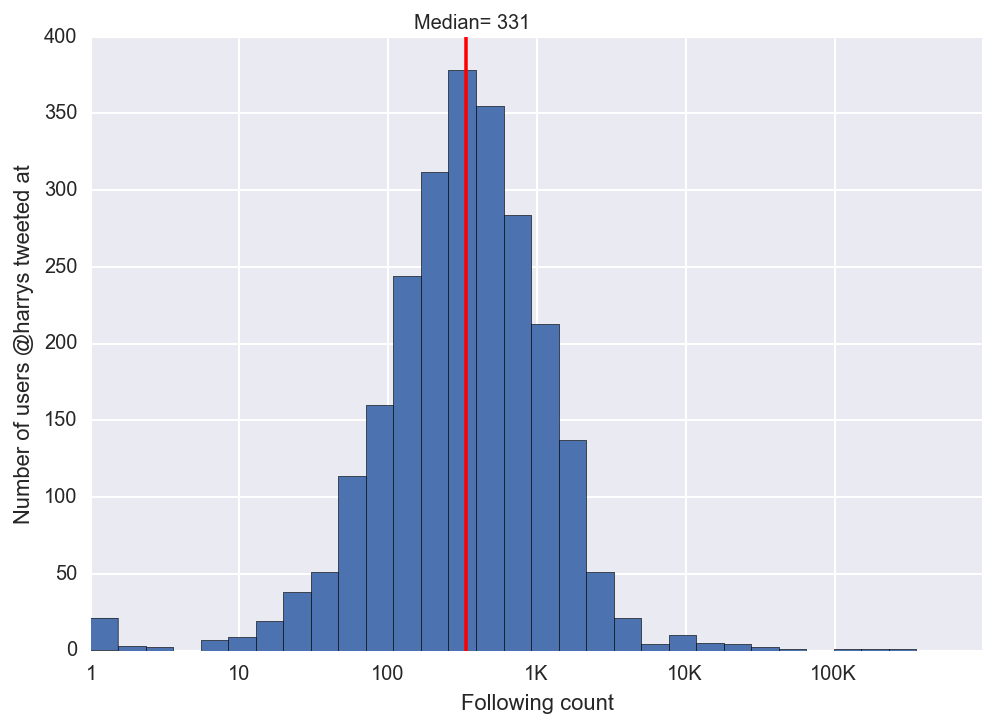

In [9]:
ax = harrys_tweets_stats['log following count'].hist(bins=30)
ax.set_xticklabels(['1','10','100','1K','10K','100K'])
ax.set_xlabel('Following count')
ax.set_ylabel('Number of users @harrys tweeted at')
ax.axvline(x=harrys_tweets_stats['log following count'].median(),color='r')#,label='Median:')# '+str(harrys_tweets_stats['log follower count'].median()))
ax.text(harrys_tweets_stats['log following count'].median()-.35,405,'Median= '+str(int(10**harrys_tweets_stats['log following count'].median())),rotation=0)

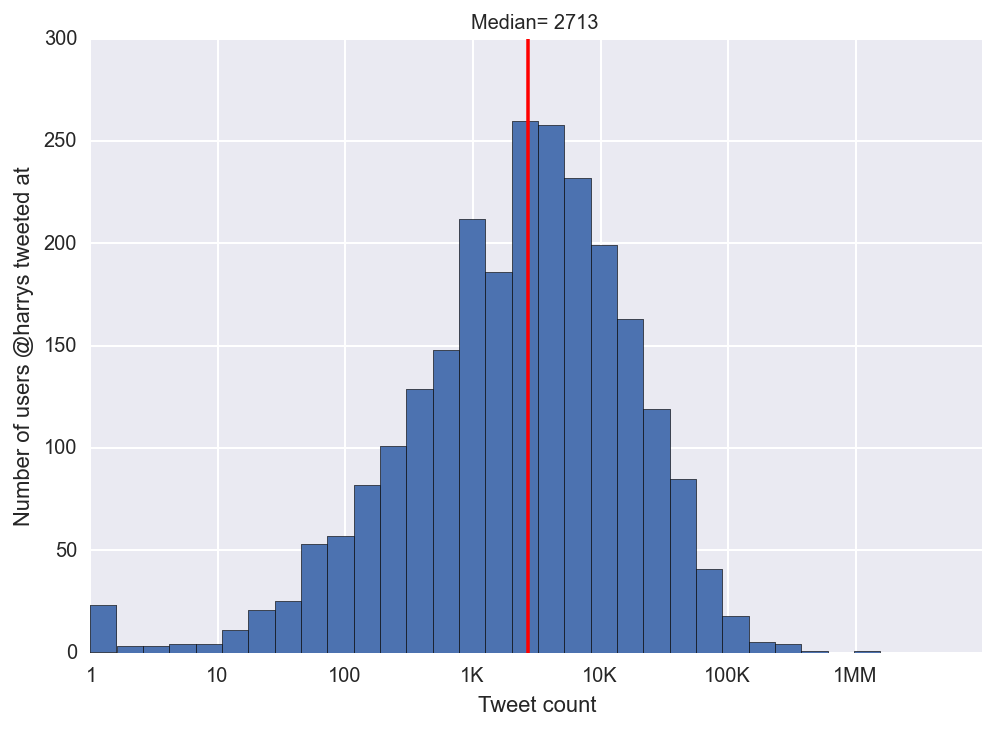

In [10]:
ax = harrys_tweets_stats['log tweet count'].hist(bins=30)
ax.set_xticklabels(['1','10','100','1K','10K','100K','1MM'])
ax.set_xlabel('Tweet count')
ax.set_ylabel('Number of users @harrys tweeted at')
ax.axvline(x=harrys_tweets_stats['log tweet count'].median(),color='r')#,label='Median:')# '+str(harrys_tweets_stats['log follower count'].median()))
ax.text(harrys_tweets_stats['log tweet count'].median()-.45,305,'Median= '+str(int(10**harrys_tweets_stats['log tweet count'].median())),rotation=0)

In [11]:
desc = harrys_tweets_stats.describe()
desc['lognormal follower count'] = 10**desc['log follower count']
desc['lognormal following count'] = 10**desc['log following count']
desc['lognormal tweet count'] = 10**desc['log tweet count']
desc

,follower count,following count,tweet count,log follower count,log following count,log tweet count,lognormal follower count,lognormal following count,lognormal tweet count
count,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,2448.000000,inf,inf,inf
mean,57868.845997,947.924020,10081.281863,2.521582,2.490735,3.331127,3.323392e+02,3.095530e+02,2.143518e+03
std,1044642.142849,8392.298989,38507.244314,0.972181,0.577917,0.893167,9.379531e+00,3.783700e+00,7.819290e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000000e+00
25%,86.000000,152.000000,657.500000,1.934498,2.181844,2.817895,8.600000e+01,1.520000e+02,6.574994e+02
50%,275.000000,332.000000,2714.000000,2.439333,2.521138,3.433609,2.750000e+02,3.320000e+02,2.713993e+03
75%,944.500000,692.000000,8951.250000,2.975202,2.840106,3.951883,9.444996e+02,6.920000e+02,8.951239e+03
max,38322914.000000,353998.000000,1564544.000000,7.583459,5.549001,6.194388,3.832291e+07,3.539980e+05,1.564544e+06


# different things in the tweet:

1. time stamp
2. is it a reply
 a. whats the time delta?
3. was it replied too
4. was it retweeted?
 a. how many times?
5. favorited? how many times?
5. is there a link?
6. is there a hashtag?

In [18]:
def dataframe_the_tweets(harrys_tweets_df):
    dic_list = []
    for tweet in harrys_tweets_df:
        dic = {}
        dic['text'] = tweet.text
        dic['timestamp'] = tweet.created_at
        dic['favorites'] = tweet.favorite_count
        dic['hashtags'] = tweet.entities['hashtags']
        dic['urls'] = tweet.entities['urls']
        dic['symbols'] = tweet.entities['symbols']
        dic['user_mentions'] = tweet.entities['user_mentions']
        if tweet.in_reply_to_status_id:
            try:
                reply_status = api.get_status(tweet.in_reply_to_status_id,monitor_rate_limit=True, wait_on_rate_limit=True)
                dic['in_reply'] = reply_status
                dic['in_reply_timestamp'] = reply_status.created_at
                dic['in_reply_text'] = reply_status.text
            except tweepy.TweepError:
                dic['in_reply'] = None
                dic['in_reply_timestamp'] = None
                dic['in_reply_text'] = None
        else:
            dic['in_reply'] = None
            dic['in_reply_timestamp'] = None
            dic['in_reply_text'] = None
        dic['retweets'] = tweet.retweet_count
        dic_list.append(dic)
    return pd.DataFrame(dic_list)
        


In [19]:
df = dataframe_the_tweets(harrys_tweets_df)

KeyboardInterrupt: 

In [44]:
df.to_pickle('harrys_tweets_df_advanced.pkl')

In [20]:
df = pd.read_pickle('harrys_tweets_df_advanced.pkl')

In [22]:
import datetime

In [23]:
ymd_timestamp = [datetime.datetime(dt.year,dt.month,dt.day) for dt in df['timestamp']]
df['ymd_timestamp'] = ymd_timestamp

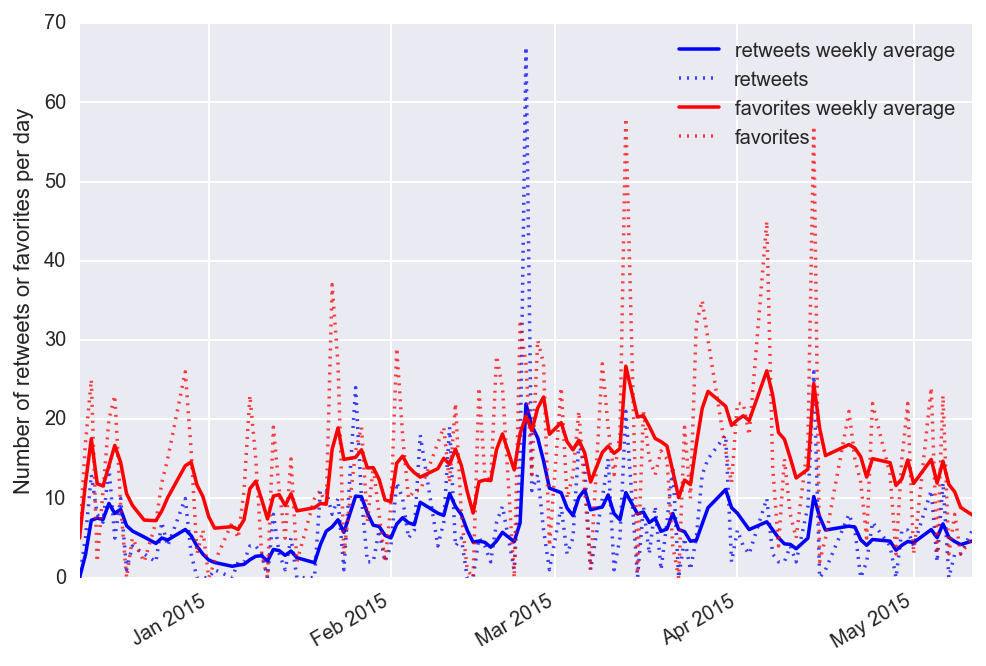

In [24]:
df_ewma = pd.DataFrame({'retweets weekly average':pd.ewma(df.groupby('ymd_timestamp')['retweets'].sum(),span=7),
           'favorites weekly average':pd.ewma(df.groupby('ymd_timestamp')['favorites'].sum(),span=7)})
ax = df_ewma['retweets weekly average'].plot(style='b-')
df.groupby('ymd_timestamp')['retweets'].sum().plot(style='b:',ax=ax,alpha=0.75)
ax = df_ewma['favorites weekly average'].plot(style='r-')
df.groupby('ymd_timestamp')['favorites'].sum().plot(style='r:',ax=ax,alpha=0.75)
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('Number of retweets or favorites per day')

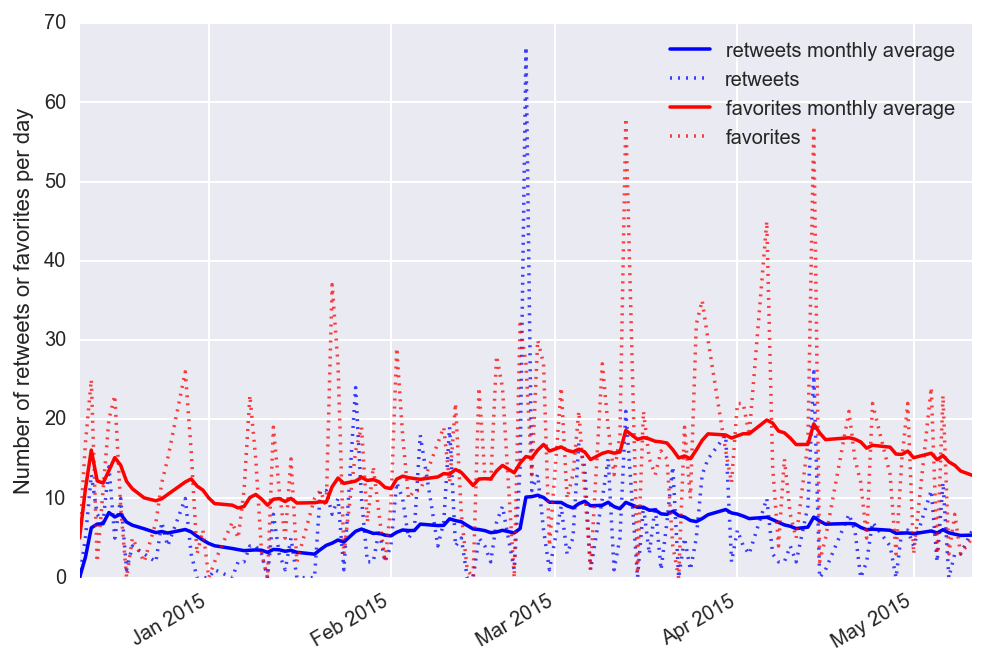

In [17]:
df_ewma = pd.DataFrame({'retweets monthly average':pd.ewma(df.groupby('ymd_timestamp')['retweets'].sum(),span=30),
           'favorites monthly average':pd.ewma(df.groupby('ymd_timestamp')['favorites'].sum(),span=30)})
ax = df_ewma['retweets monthly average'].plot(style='b-')
df.groupby('ymd_timestamp')['retweets'].sum().plot(style='b:',ax=ax,alpha=0.75)
ax = df_ewma['favorites monthly average'].plot(style='r-')
df.groupby('ymd_timestamp')['favorites'].sum().plot(style='r:',ax=ax,alpha=0.75)
ax.legend()

ax.set_xlabel('')
ax.set_ylabel('Number of retweets or favorites per day')

In [36]:
harrys_tweets_df.tail()

3223    Status(contributors=None, truncated=False, tex...
3224    Status(contributors=None, truncated=False, tex...
3225    Status(contributors=None, truncated=False, tex...
3226    Status(contributors=None, truncated=False, tex...
3227    Status(contributors=None, truncated=False, tex...
dtype: object

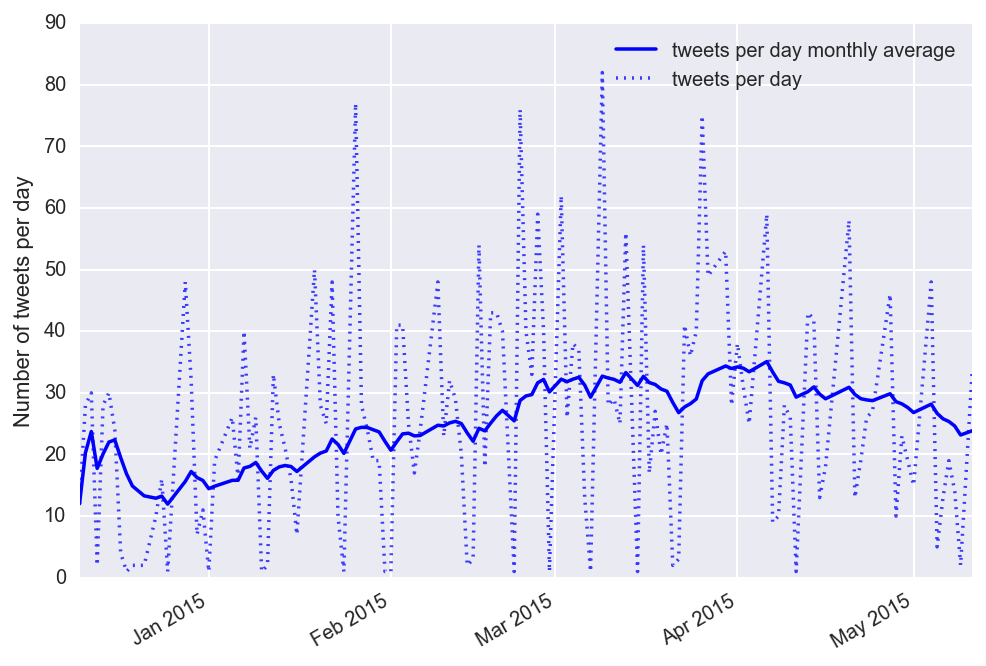

In [58]:
tpd = df.groupby('ymd_timestamp')['retweets'].apply(lambda x: len(x))
df_tpd = pd.DataFrame({'tweets per day weekly average':pd.ewma(tpd,span=7),
                       'tweets per day monthly average':pd.ewma(tpd,span=30),
           'tweets per day':tpd})
#ax = df_tpd['tweets per day weekly average'].plot(style='b-')
ax = df_tpd['tweets per day monthly average'].plot(style='b-')
df_tpd['tweets per day'].plot(style='b:',alpha=0.75)
ax.legend()

ax.set_xlabel('')
ax.set_ylabel('Number of tweets per day')

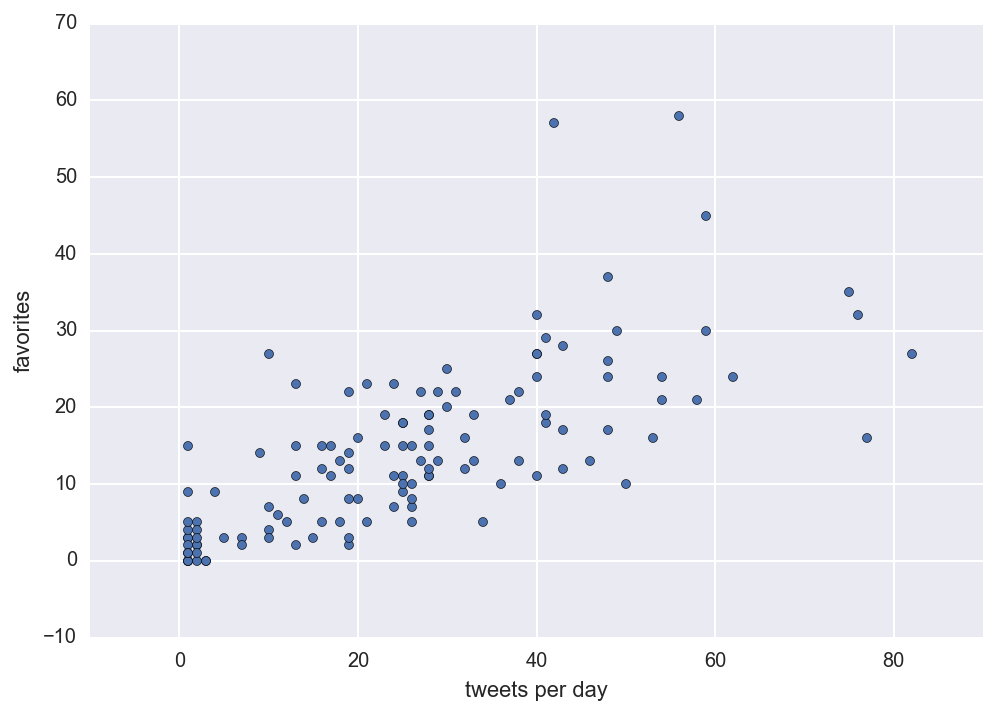

In [51]:
df_rt_fv = pd.DataFrame({'retweets':df.groupby('ymd_timestamp')['retweets'].sum(),
            'favorites':df.groupby('ymd_timestamp')['favorites'].sum(),
            'tweets per day':df.groupby('ymd_timestamp')['retweets'].apply(lambda x: len(x)),
            'const':1})
df_rt_fv.plot(kind='scatter',y='favorites',x='tweets per day')

In [97]:
replies = [isinstance(ts,pd.tslib.Timestamp) for ts in df['in_reply_timestamp']]
df_replies = df[replies]

timedelta = [ts-irts for ts,irts in zip(df_replies['timestamp'],df_replies['in_reply_timestamp'])]
df_replies['Reply time (s)'] = [td.total_seconds() for td in timedelta]
df_replies['Reply time (m)'] = [td.total_seconds()/60. for td in timedelta]
df_replies['Reply time (h)'] = [td.total_seconds()/3600. for td in timedelta]
df_replies = df_replies.set_index('ymd_timestamp')


/Users/matthewsochor/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/matthewsochor/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/matthewsochor/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentat

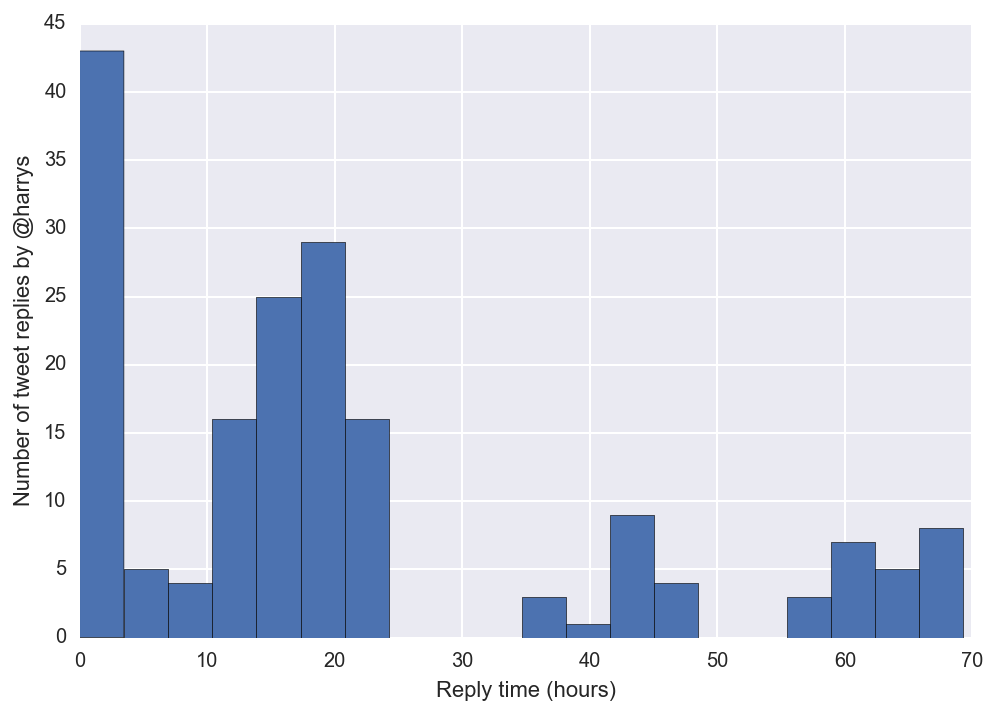

In [98]:
ax = df_replies['Reply time (h)'].hist(bins=20)
ax.set_xlabel('Reply time (hours)')
ax.set_ylabel('Number of tweet replies by @harrys')

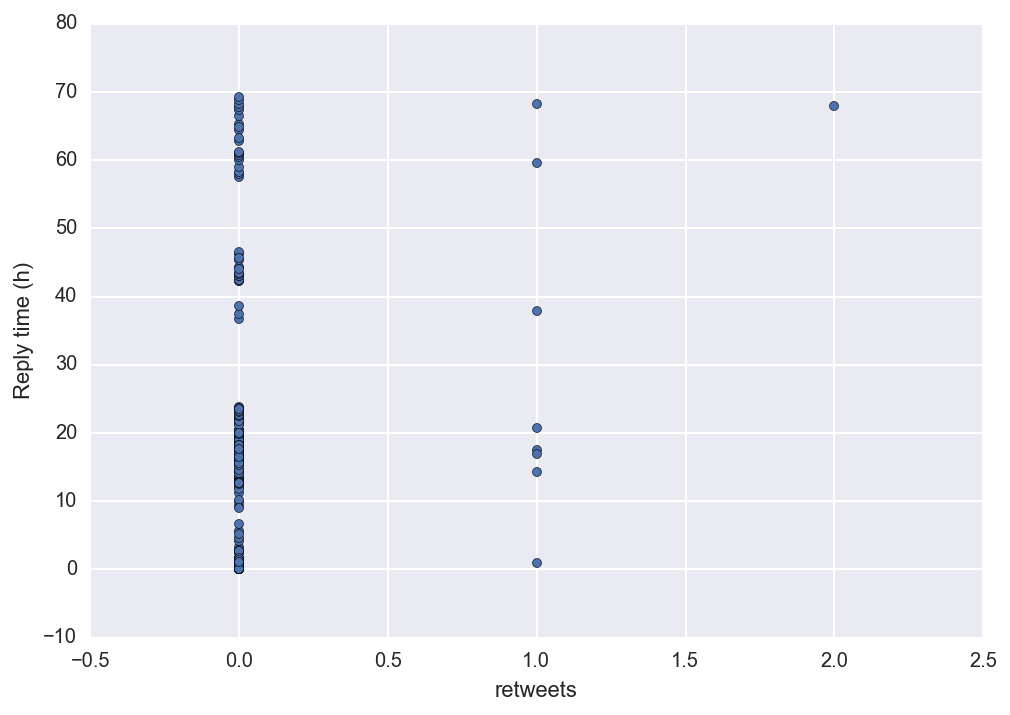

In [159]:
df_replies.plot(kind='scatter',x='retweets',y='Reply time (h)')

In [116]:
x

favorites                                                             1
hashtags                                                             []
in_reply              Status(contributors=None, truncated=False, tex...
in_reply_text         Humorous blog post by @harrys to lighten your ...
in_reply_timestamp                                  2015-05-11 15:09:43
retweets                                                              0
symbols                                                              []
text                  @UrbanCr1ck3t Love that piece. Glad you enjoye...
timestamp                                           2015-05-11 16:28:15
urls                                                                 []
user_mentions         [{u'indices': [0, 13], u'id_str': u'33696879',...
ymd_timestamp                                       2015-05-11 00:00:00
Name: 0, dtype: object

In [110]:
user_stats = harrys_tweets_stats.set_index('user')

In [117]:
user_stats.ix[u'UrbanCr1ck3t']

follower count          431.000000
following count         391.000000
tweet count            5921.000000
log follower count        2.634477
log following count       2.592177
log tweet count           3.772395
Name: UrbanCr1ck3t, dtype: float64

In [138]:
data = []
for i,user_mentions in enumerate(df['user_mentions']):
    
    if user_mentions:
        for mention in user_mentions:
            try:
                data.append({'ymd_timestamp':df.iloc[i]['ymd_timestamp'],
                             'screen name':mention['screen_name'],
                             'follower count':user_stats.ix[mention['screen_name']]['follower count'],
                             'following count':user_stats.ix[mention['screen_name']]['following count'],
                             'tweet count':user_stats.ix[mention['screen_name']]['tweet count'],
                             'log follower count':user_stats.ix[mention['screen_name']]['log follower count'],
                             'log following count':user_stats.ix[mention['screen_name']]['log following count'],
                             'log tweet count':user_stats.ix[mention['screen_name']]['log tweet count']})
            except:
                pass
    
            

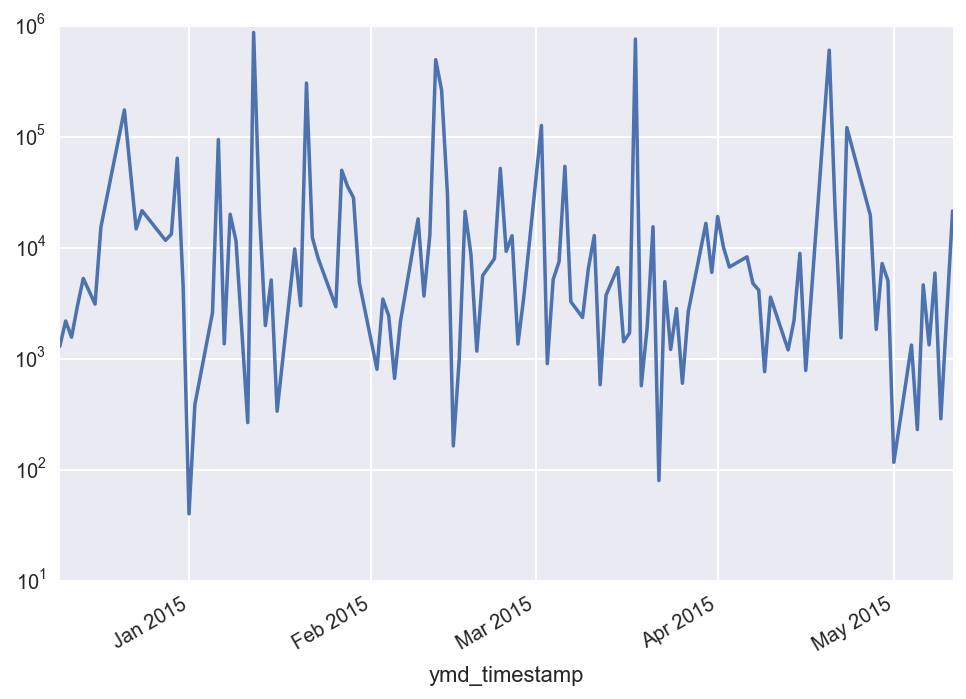

In [141]:
demo = pd.DataFrame(data)
ax = demo.groupby('ymd_timestamp')['follower count'].mean().plot()
ax.set_yscale('log')

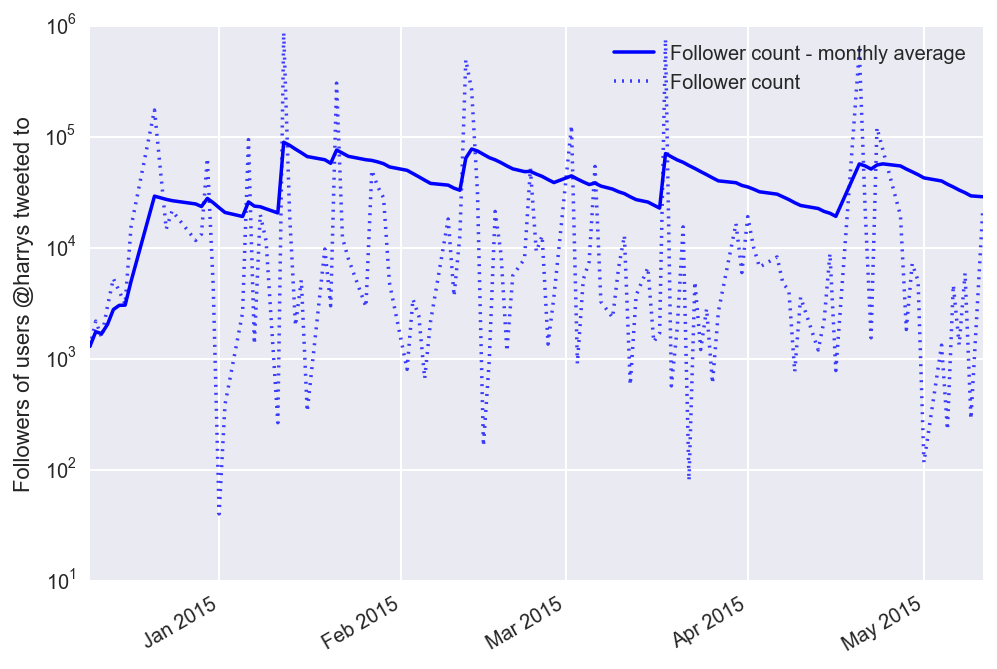

In [153]:


tpd = demo.groupby('ymd_timestamp')['follower count'].mean()
df_tpd = pd.DataFrame({'Follower count - monthly average':pd.ewma(tpd,span=30),
           'Follower count':tpd})
#ax = df_tpd['tweets per day weekly average'].plot(style='b-')
ax = df_tpd['Follower count - monthly average'].plot(style='b-')
df_tpd['Follower count'].plot(style='b:',alpha=0.75)
ax.legend()

ax.set_xlabel('')
ax.set_ylabel('Followers of users @harrys tweeted to')
ax.set_yscale('log')

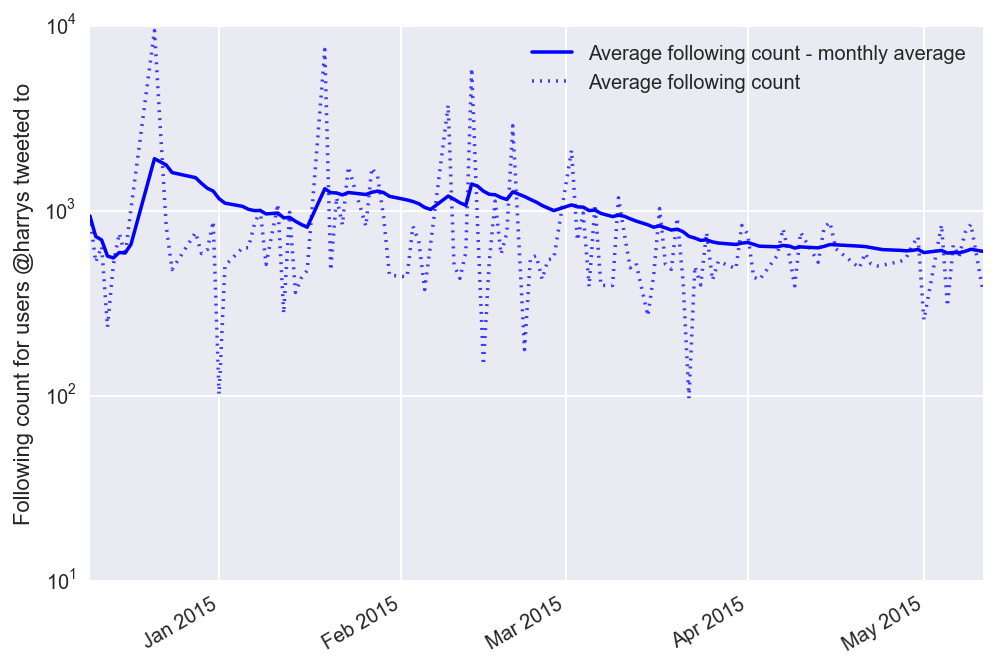

In [152]:
tpd = demo.groupby('ymd_timestamp')['following count'].mean()
df_tpd = pd.DataFrame({'Average following count - monthly average':pd.ewma(tpd,span=30),
           'Average following count':tpd})
#ax = df_tpd['tweets per day weekly average'].plot(style='b-')
ax = df_tpd['Average following count - monthly average'].plot(style='b-')
df_tpd['Average following count'].plot(style='b:',alpha=0.75)
ax.legend()

ax.set_xlabel('')
ax.set_ylabel('Following count for users @harrys tweeted to')
ax.set_yscale('log')

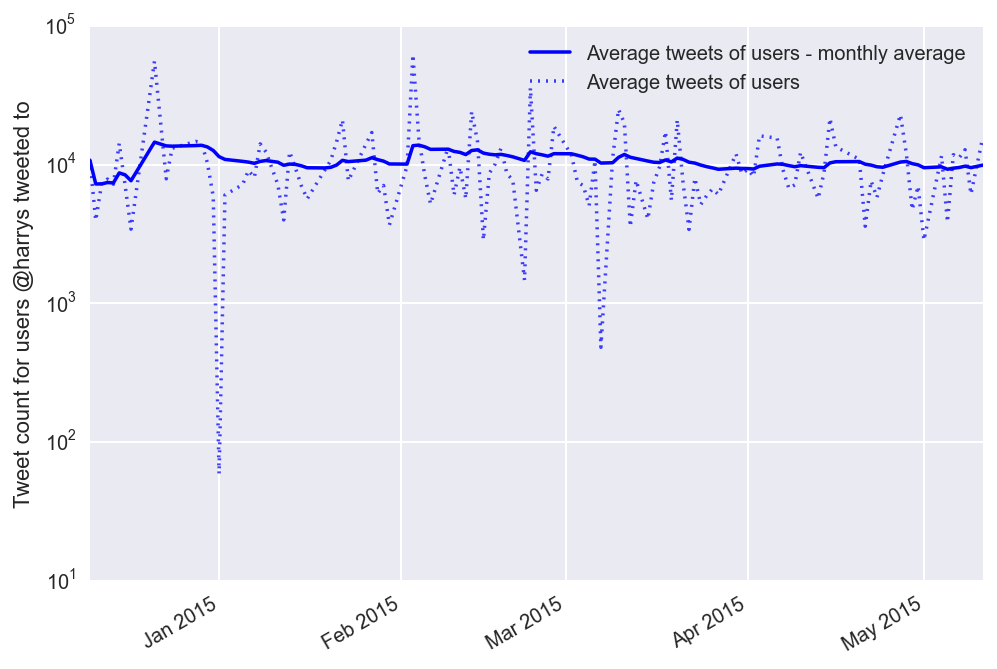

In [150]:
tpd = demo.groupby('ymd_timestamp')['tweet count'].mean()
df_tpd = pd.DataFrame({'Average tweets of users - monthly average':pd.ewma(tpd,span=30),
           'Average tweets of users':tpd})
#ax = df_tpd['tweets per day weekly average'].plot(style='b-')
ax = df_tpd['Average tweets of users - monthly average'].plot(style='b-')
df_tpd['Average tweets of users'].plot(style='b:',alpha=0.75)
ax.legend()

ax.set_xlabel('')
ax.set_ylabel('Tweet count for users @harrys tweeted to')
ax.set_yscale('log')